# Image classifier in AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, one might want to include an image classifier in a smart phone app. I used a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I trained an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice I trained this classifier, then exported it for use in my application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, Here are a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use the trained model to perform inference on flower images.

## Import Resources

In [2]:
# The new version of dataset is only available in the tfds-nightly package.
%pip --no-cache-dir install tensorflow-datasets --user
%pip --no-cache-dir install tfds-nightly --user
# DON'T MISS TO RESTART THE KERNEL

     |████████████████████████████████| 4.2 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 37.1 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

tfds.disable_progress_bar()

In [6]:
# Make all other necessary imports.
import time
import numpy as np
import matplotlib.pyplot as plt
import json as json

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#from workspace_utils import active_session
#from workspace_utils import keep_awake

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

Here I used `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  I need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but I'll still need to normalize and resize the images to the appropriate size.

In [7]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# %pip --no-cache-dir install tfds-nightly

# Load the dataset with TensorFlow Datasets. use tfds.load()
# Create a training set, a validation set and a test set.
dataset, dataset_info = tfds.load("oxford_flowers102", as_supervised=True, with_info=True)
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']
print(dataset_info)

usage: download_and_prepare.py build [-h] [--helpfull]
                                     [--module_import MODULE_IMPORT]
                                     [--builder_config_id BUILDER_CONFIG_ID]
                                     [--datasets DATASETS_KEYWORD [DATASETS_KEYWORD ...]]
                                     [--overwrite]
                                     [--max_examples_per_split [MAX_EXAMPLES_PER_SPLIT]]
                                     [--data_dir DATA_DIR]
                                     [--download_dir DOWNLOAD_DIR]
                                     [--extract_dir EXTRACT_DIR]
                                     [--manual_dir MANUAL_DIR]
                                     [--add_name_to_manual_dir]
                                     [--config CONFIG]
                                     [--config_idx CONFIG_IDX]
                                     [--imports IMPORTS]
                                     [--register_checksums]
                

## Explore the Dataset

In [8]:
# Get the number of examples in each set from the dataset info.
num_test_samples = dataset_info.splits['test'].num_examples
num_training_samples = dataset_info.splits['train'].num_examples
num_validation_samples = dataset_info.splits['validation'].num_examples

# Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes

print('There are {:,} images in the training set'.format(num_training_samples))
print('There are {:,} images in the validation set'.format(num_validation_samples))
print('There are {:,} images in the test set'.format(num_test_samples))
print('There are {:,} classes'.format(num_classes))


There are 1,020 images in the training set
There are 1,020 images in the validation set
There are 6,149 images in the test set
There are 102 classes


In [9]:
# Print the shape and corresponding label of 3 images in the training set.
for image, label in enumerate(training_set.take(3)):
    print('Image {} shape: {} label: {}'.format(image+1, label[0].shape, label[1]))


Image 1 shape: (500, 667, 3) label: 72
Image 2 shape: (500, 666, 3) label: 84
Image 3 shape: (670, 500, 3) label: 70


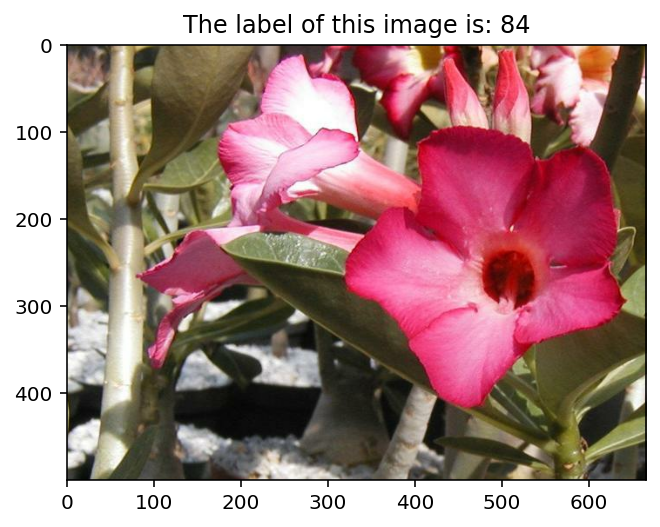

In [10]:
# Plot 1 image from the training set. 
# Set the title of the plot to the corresponding image label. 
for image, label in dataset['train'].take(2):
    image = image.numpy()
    label = label.numpy()

plt.figure()
plt.title('The label of this image is: {}'. format(label))
plt.imshow(image)
plt.show()


### Label Mapping

Load in a mapping from label to category name, which is in the file `label_map.json`. It's a JSON object which one can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [12]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)
    
print(class_names)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

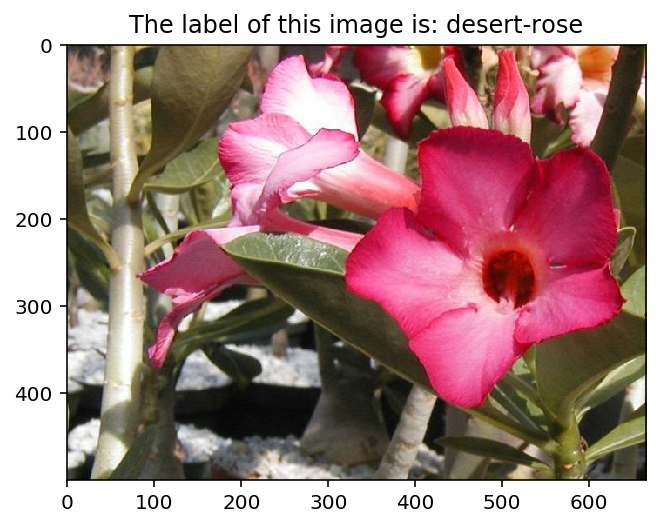

In [11]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image, label in dataset['train'].take(2):
    image = image.numpy()
    label = label.numpy()

plt.figure()
plt.title('The label of this image is: {}'. format(class_names[str(label+1)]))
plt.imshow(image)
plt.show()

## Create Pipeline

In [12]:
# Create a pipeline for each set.
batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = training_set.shuffle(num_training_samples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. I use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 


In [13]:
# Build and train your network.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

EPOCHS = 10

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/10
32/32 [==============================] - 15s 473ms/step - loss: 4.3275 - accuracy: 0.1010 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 7s 217ms/step - loss: 2.1099 - accuracy: 0.6882 - val_loss: 2.0227 - val_accuracy: 0.6451
Epoch 3/10
32/32 [==============================] - 6s 199ms/step - loss: 1.1201 - accuracy: 0.8873 - val_loss: 1.5476 - val_accuracy: 0.7343
Epoch 4/10
32/32 [==============================] - 6s 200ms/step - loss: 0.6787 - accuracy: 0.9578 - val_loss: 1.2974 - val_accuracy: 0.7637
Epoch 5/10
32/32 [==============================] - 6s 200ms/step - loss: 0.4450 - accuracy: 0.9882 - val_loss: 1.1638 - val_accuracy: 0.7725
Epoch 6/10
32/32 [==============================] - 7s 213ms/step - loss: 0.3180 - accuracy: 0.9931 - val_loss: 1.0755 - val_accuracy: 0.7882
Epoch 7/10
32/32 [==============================] - 7s 208ms/step - loss: 0.2407 - accuracy: 0.9980 - val_loss: 1.0126 - val_accuracy: 0.79

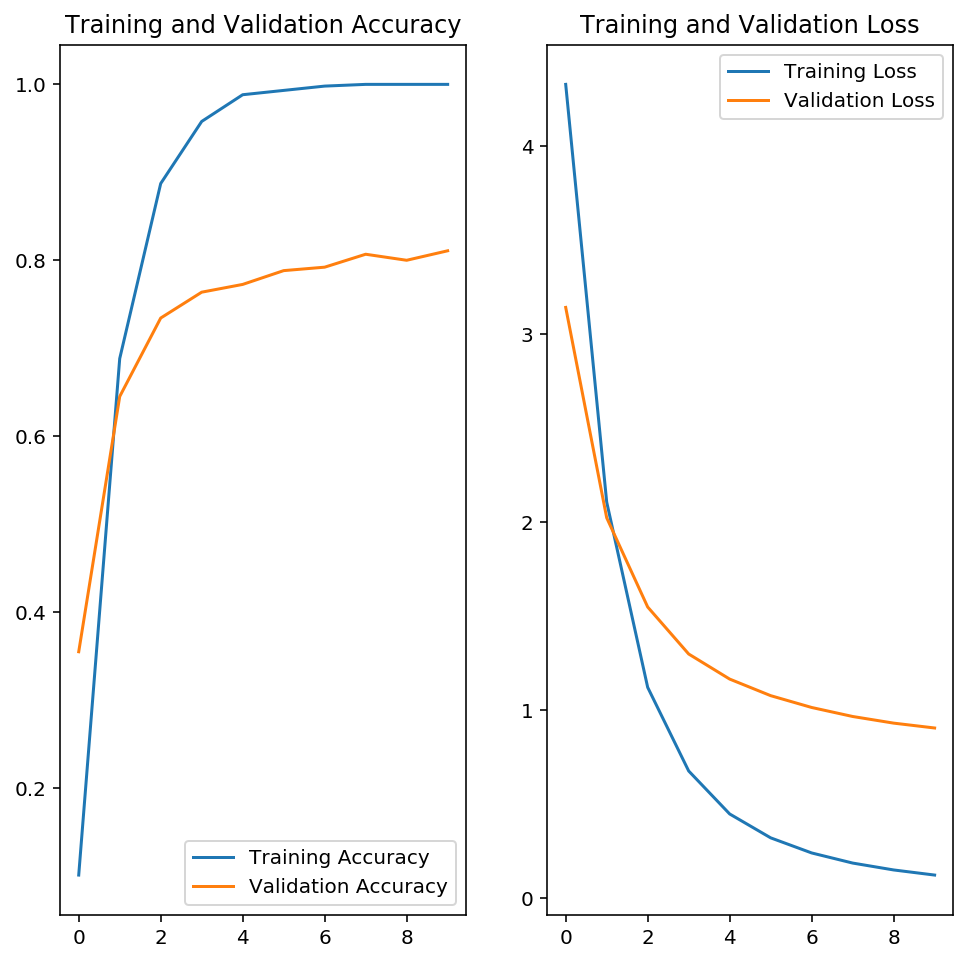

In [15]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_acc, label='Training Accuracy')
plt.plot(epochs_range, validation_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

Test your trained network on test data, which has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. 

In [16]:
# Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))


193/193 [==============================] - 18s 96ms/step - loss: 1.0199 - accuracy: 0.7696

Loss on the TEST Set: 1.020
Accuracy on the TEST Set: 76.956%


## Save the Model

Save the model as a Keras model (as an HDF5 file) so we can load it later for making inference. 

In [17]:
# Save your trained model as a Keras model.
t = time.time()

saved_keras_model_fpath = './{}.h5'.format(int(t))
print(saved_keras_model_fpath)
model.save(saved_keras_model_fpath)


./1604677046.h5


## Load the Keras Model

Load the Keras model that saved above.

In [18]:
# Load the Keras model
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_fpath,
                                                 custom_objects={'KerasLayer': hub.KerasLayer})

reloaded_keras_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now I wrote a function that uses the trained network for inference. I wrote a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

The `predict` function will use `PIL` to load the image from the given `image_path`. I used the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. I can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by our model. I wrote a separate function called `process_image` that performs the pre-processing. It will be then called from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, I converted the image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, I'll also need to normalize the pixel values. 

Finally, convert the image back to a NumPy array using the `.numpy()` method.

In [19]:
# Create the process_image function
def process_image(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image.numpy()

I checked the `process_image` function with 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by the `process_image` function. If the `process_image` function works, the plotted image should be the correct size. 

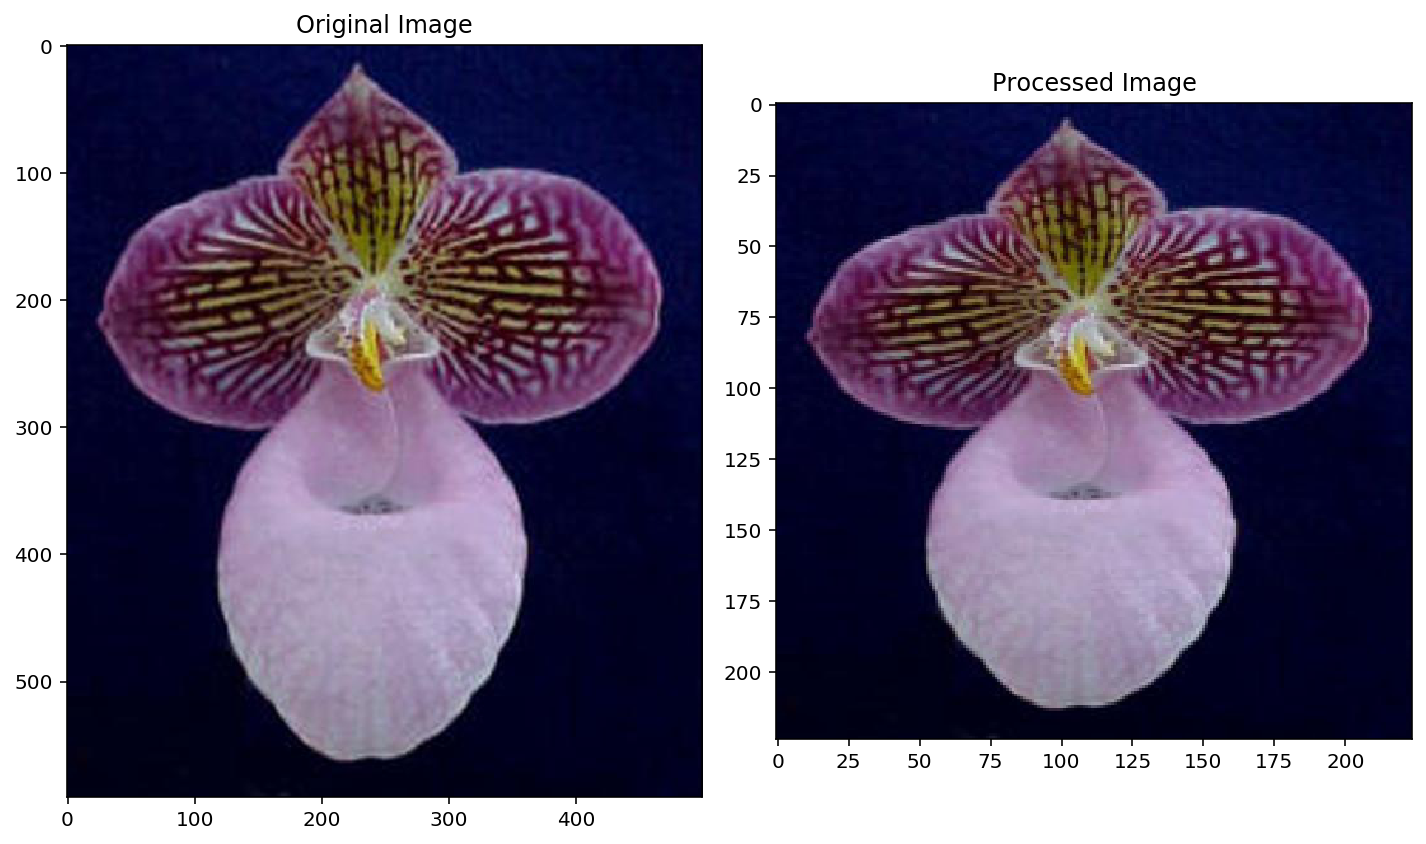

In [20]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

After I can get images in the correct format, it's time to write the `predict` function for making inference with the model.

### Inference

The `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

The `predict` function will use `PIL` to load the image from the given `image_path`. I used the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. I converted this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. I used the `np.expand_dims()` function to add the extra dimension. 

In [21]:
# Create the predict function
def predict(image_path, model, top_k):
    img = Image.open(image_path)
    image = np.asarray(img)
    processed_image = process_image(image)
    processed_image = np.expand_dims(processed_image,axis=0)
    ps = model.predict(processed_image)
    probs,ind = tf.math.top_k(ps, k=top_k, sorted=True)
    return probs.numpy()[0], ind.numpy()[0]

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
probs, classes = predict(image_path,model,5)
print(probs)
print(classes)

[9.9698883e-01 7.0062443e-04 5.2778586e-04 4.8926543e-04 2.2402014e-04]
[ 1 67  5 79  2]


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check predictions I tested 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by our model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

I converted from the class integer labels to actual flower names using `class_names`. 

['./test_images/orange_dahlia.jpg', './test_images/wild_pansy.jpg', './test_images/hard-leaved_pocket_orchid.jpg', './test_images/cautleya_spicata.jpg']


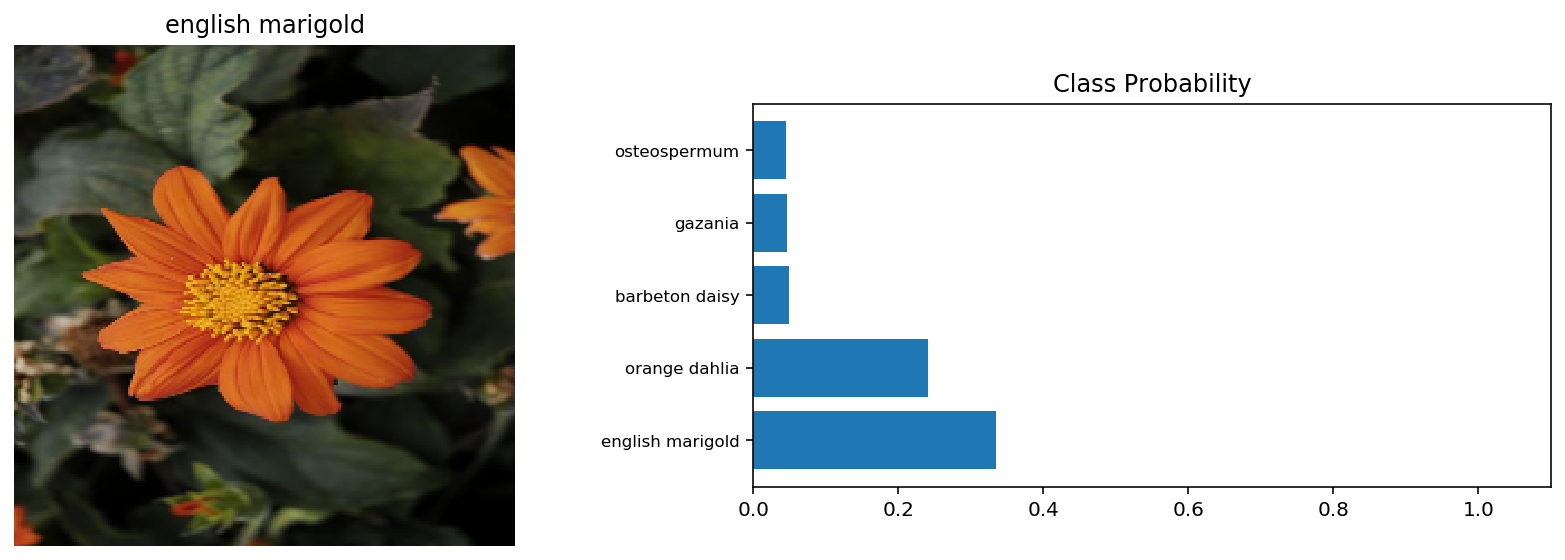

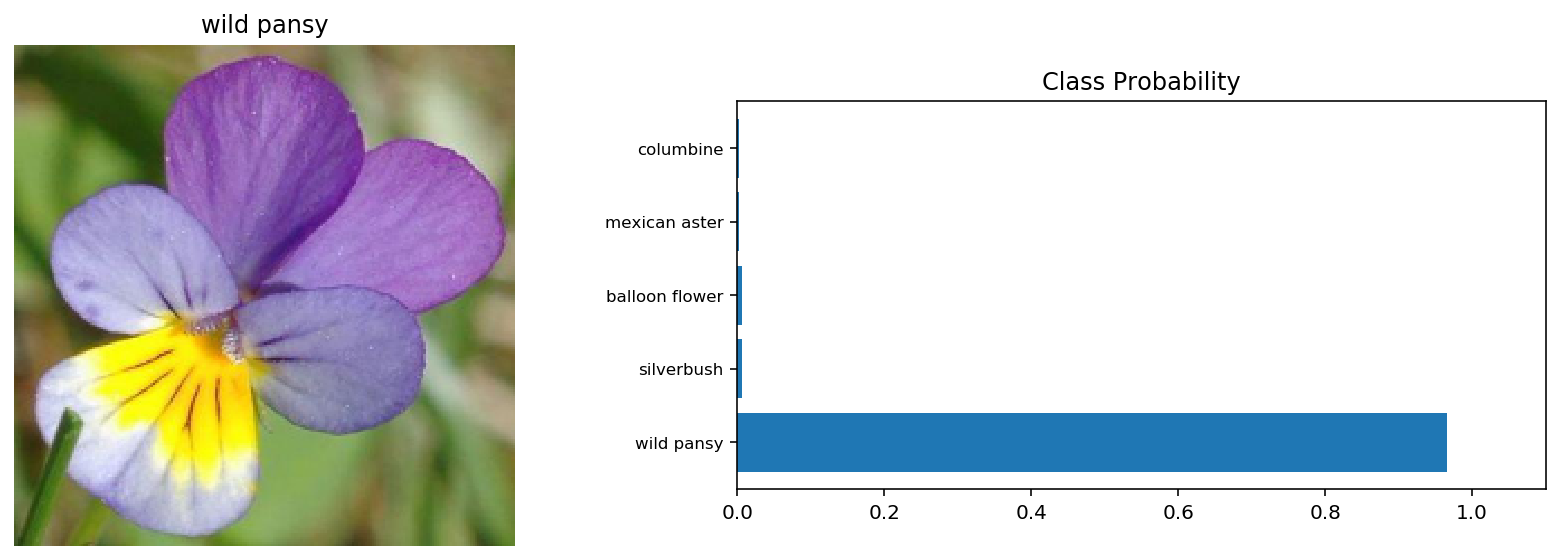

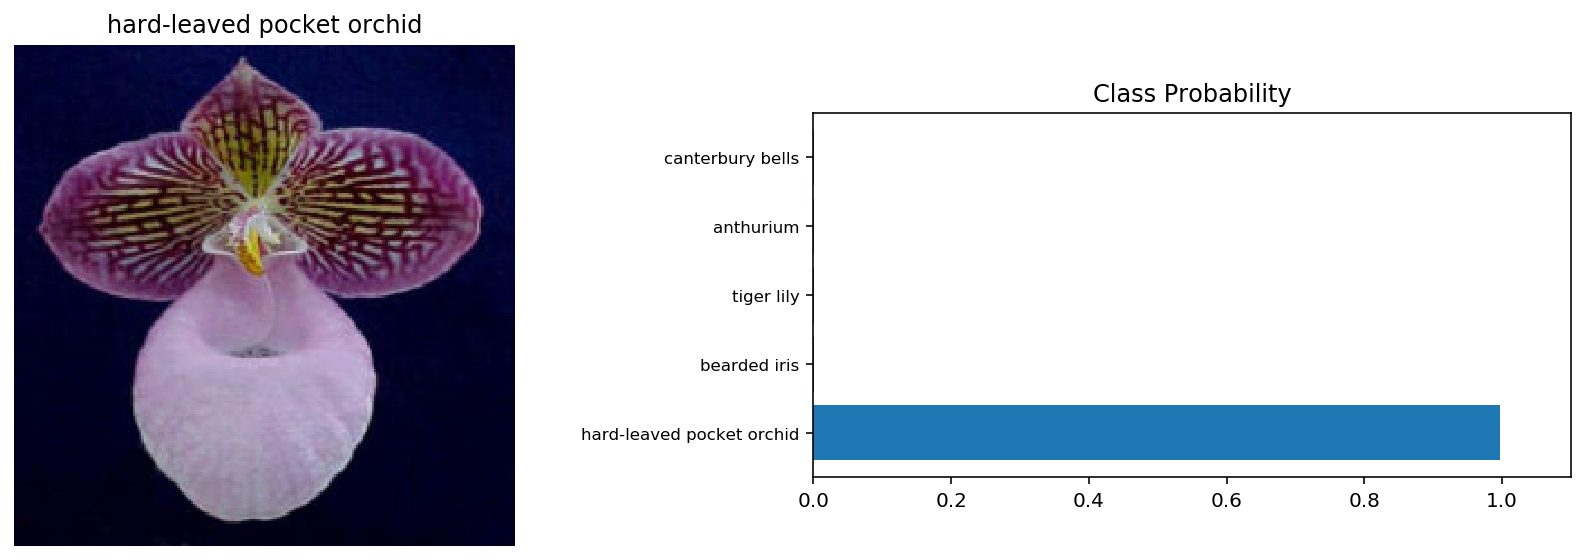

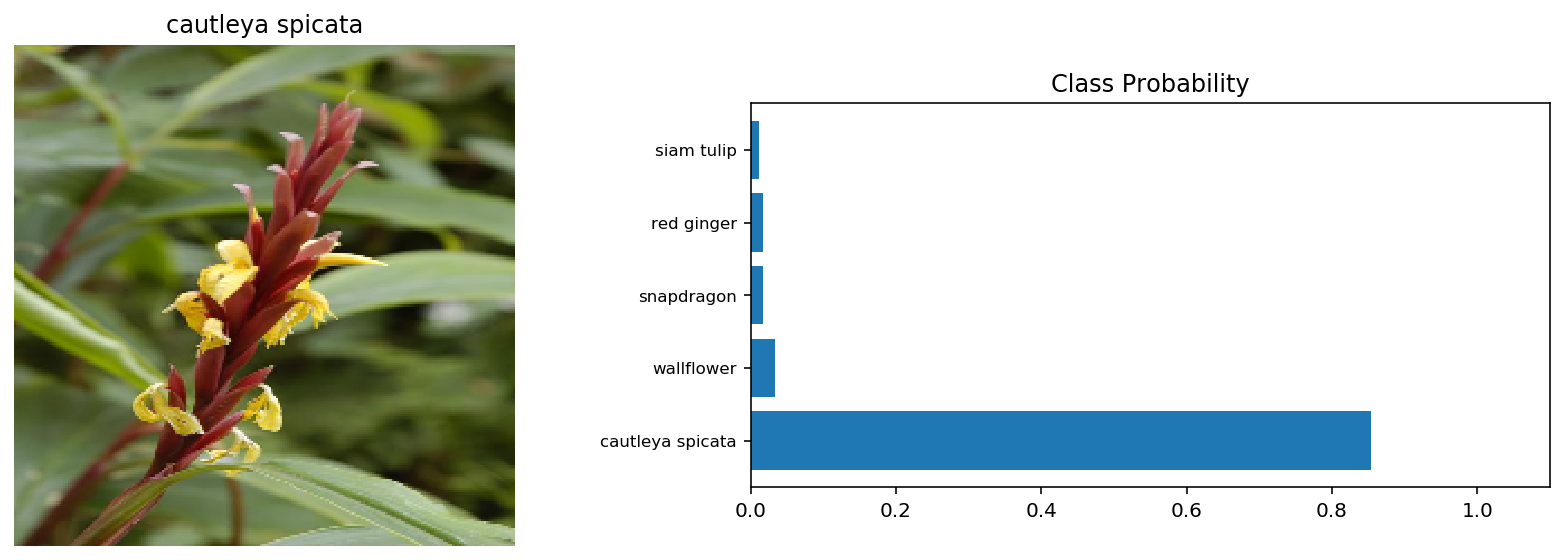

In [22]:
# Plot the input image along with the top 5 classes
import glob 
files = glob.glob('./test_images/*.jpg')  
print(files)

for image_path in files:
    probs, classes = predict(image_path,model,5)
    img = Image.open(image_path)
    image = process_image(np.asarray(img))
    label = classes[0]
    c_names = []
    for v in classes:
        c_names.append(class_names[str(v+1)]) 

    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    ax1.imshow(image, cmap = plt.cm.binary)
    ax1.axis('off')
    ax1.set_title(format(class_names[str(label+1)]))
    ax2.barh(np.arange(5), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(c_names, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()